In [0]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y='+str(data_sample[1].item()))


In [0]:
IMAGE_SIZE = 16
composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

In [3]:
train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=composed)
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=composed)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [4]:
train_dataset[3][1]

1

AttributeError: ignored

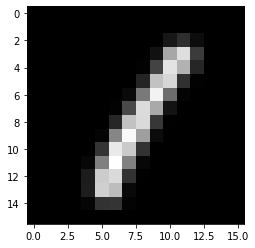

In [5]:
show_data(train_dataset[3])

In [0]:
class CNN(nn.Module):
    def __init__(self, out_1=16, out_2=32):
        super(CNN, self).__init__()
        self.cnn1=nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2=nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1=nn.Linear(out_2*4*4,10)
    
    def forward(self, x):
        x=self.cnn1(x)
        x=torch.relu(x)
        x=self.maxpool1(x)
        x=self.cnn2(x)
        x=torch.relu(x)
        x=self.maxpool2(x)
        x=x.view(x.size(0),-1)
        x=self.fc1(x)
        return x


In [0]:
class CNN_batch(nn.Module):
    def __init__(self, out_1=16, out_2=32, number_of_classes=10):
        super(CNN_batch, self).__init__()
        self.cnn1=nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.conv1_bn=nn.BatchNorm2d(out_1)

        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2=nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.conv2_bn=nn.BatchNorm2d(out_2)

        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1=nn.Linear(out_2*4*4, number_of_classes)
        self.bn_fc1 = nn.BatchNorm1d(10)
    
    def forward(self, x):
        x=self.cnn1(x)
        x=self.conv1_bn(x)
        x=torch.relu(x)
        x=self.maxpool1(x)
        x=self.cnn2(x)
        x=self.conv2_bn(x)
        x=torch.relu(x)
        x=self.maxpool2(x)
        x=x.view(x.size(0),-1)
        x=self.fc1(x)
        x=self.bn_fc1(x)
        return x


In [0]:
def train_model(model,train_loader, validation_loader, optimizer, n_epochs=4):
    
    N_test=len(validation_dataset)
    accuracy_list=[]
    loss_list=[]
    for epoch in range(n_epochs):
        for x, y in train_loader:
            model.train()
            optimizer.zero_grad()
            z= model(x)
            loss=criterion(z, y)
            loss.backward()
            optimizer.step()
            loss_list.append(loss.data)

        correct=0
        for x_test, y_test in validation_loader:
            model.eval()
            z = model(x_test)
            _,yhat=torch.max(z.data,1)
            correct+=(yhat==y_test).sum().item()
        accuracy = correct/N_test
        accuracy_list.append(accuracy)
        
    return accuracy_list, loss_list

In [0]:
model = CNN(out_1=16, out_2=32)

In [0]:
criterion = nn.CrossEntropyLoss()
learning_rate=0.1
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)
train_loader=torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader=torch.utils.data.DataLoader(dataset=train_dataset, batch_size=5000)

In [0]:
accuracy_list_normal, loss_list_normal = train_model(model=model, n_epochs=10, train_loader=train_loader, validation_loader=validation_loader, optimizer=optimizer)

In [0]:
model_batch = CNN_batch(out_1=16, out_2=32)
criterion = nn.CrossEntropyLoss()
learning_rate=0.1
optimizer=torch.optim.SGD(model_batch.parameters(), lr=learning_rate)
accuracy_list_batch, loss_list_batch = train_model(model=model_batch, n_epochs=10, train_loader=train_loader, validation_loader=validation_loader, optimizer=optimizer)

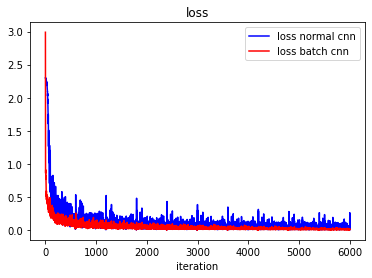

In [13]:
plt.plot(loss_list_normal, 'b', label='loss normal cnn')
plt.plot(loss_list_batch, 'r', label='loss batch cnn')
plt.xlabel('iteration')
plt.title("loss")
plt.legend()

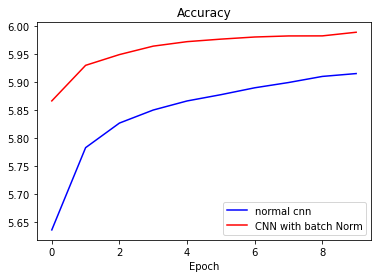

In [14]:
plt.plot(accuracy_list_normal, 'b', label='normal cnn')
plt.plot(accuracy_list_batch, 'r', label='CNN with batch Norm')
plt.xlabel('Epoch')
plt.title("Accuracy")
plt.legend()
plt.show()